In [2]:
%reload_ext autoreload
%autoreload 2
import glob
import numpy as np
import logging
import os
import csv

from pyrfu import mms
from pyrfu import pyrf

# Suppress INFO messages
logger = logging.getLogger()
logger.setLevel(logging.WARNING)  # Suppress INFO messages

def _read_regionfiles_to_swtints(folder, ic):
    print(f'Region files for MMS{ic} at...',end='')
    
    # Get region file for specified S/C names by glob
    dir_regs = "mms-regionfiles/"
    file_pattern = dir_regs + f"mms{ic}_edp_sdp_regions_*"
    filenames = glob.glob(file_pattern)
    print(f'{file_pattern}')
    
    # Initialize an empty list to store the tint pairs
    sw_tints = []

    for filepath in filenames:
        print('\t'+filepath)
        # Load data with times and region flags
        region_data = np.genfromtxt(filepath, skip_header=True, dtype=str)
        times, region_flags = np.hsplit(region_data, 2)

        # Iterate through rows and check region flag for solar wind region (flag == '1')
        nrows = len(times)
        for row in range(1, nrows - 1):
            if region_flags[row] == '1':
                # Create a tint spanning from times[i-1] to times[i+1]
                sw_tint = [times[row][0][:-1], times[row+1][0][:-1]]
                
                # Prevent duplicates: Check if tint is unique. If not, do not add
                if sw_tint not in sw_tints:
                    sw_tints.append(sw_tint)

    # Convert the list of tints to a NumPy array
    sw_tints = np.array(sw_tints)
    filename = f'mms{ic}_sw_tints.txt'
    print('\t'+20*'-')
    print('\t>'+f' Saving to {folder+filename}...')
    print('\t'+20*'-'+'\n')
    np.savetxt(folder+filename, sw_tints, fmt='%s', delimiter=' ')
    return sw_tints, filename
        


def _check_vsc(ts_mask, tint, ic):
    try:
        vsc_ = mms.get_data("v_edp_fast_l2", tint, ic)
    except FileNotFoundError:
        # print('NO EDP DATA FOUND FOR TINT', tint, '--- SKIPPING!')
        return None
    
    vsc = vsc_.drop_duplicates(dim='time')
    # ts_mask = pyrf.resample(ts_mask, vsc.time)
    vsc = pyrf.resample(vsc, ts_mask.time)

    if vsc.time.size > 0:
        # ts_mask[np.isnan(vsc)] = np.nan
        ts_mask[np.isnan(vsc)] = 0

    else:
        # print('SPACECRAFT POTENTIAL EMPTY')
        # ts_mask[:] = np.nan
        ts_mask[:] = 0

        
    return ts_mask

def _check_aspoc(ts_mask, tint, ic):
    try:
        aspoc = mms.get_data('ionc_aspoc_srvy_l2', tint, ic)
    except FileNotFoundError:
        # print('NO ASPOC DATA FOR', tint, '--- SKIPPING')
        return None

    # Keep only data where ASPOC is OFF (< 5), else NaN
    aspoc_off = aspoc.where(aspoc < 2, other=0)

    ts_mask = pyrf.resample(ts_mask, aspoc_off.time)
    # ts_mask[np.isnan(aspoc_off)] = np.nan
    ts_mask[np.isnan(aspoc_off)] = 0

    
    return ts_mask

def _split_tint(data, tint):
    # Identify the time index where data jumps to/from NaN
    diff = data.differentiate(coord='time')
    diff_norm = diff / np.max(diff)
    toggle_idxs = np.where(np.abs(diff_norm) > 0.1)[0]
    if data.data[-1] == 1.0:
        toggle_idxs = np.append(toggle_idxs, -1)
    valid_tints = []
    start = 0
    for idx in toggle_idxs:
        start_time, end_time = data.time.data[start], data.time.data[idx]
        dt = np.timedelta64(end_time - start_time)
        if (np.all(data.data[start:idx] == 1)) & (dt > np.timedelta64(10,'s')):
            
            valid_tint = [str(start_time), str(end_time)]
            valid_tints.append(valid_tint)
            
        start = idx+1

    if len(valid_tints) > 0:
        # print(f'\tCutting tint from {tint} to:')
        for valid_tint in valid_tints:
            a = 0
            # print(f'\t{valid_tint}')

    else:
        # print('\tNO INTERVALS WHERE DATA IS NaN WAS FOUND.')
        valid_tints = tint
    return valid_tints

def _check_swmode(tint, ic):
    ### Detect FPI operational mode
    # 0 - Solar wind mode OFF
    # 1 - Solar wind mode ON
    # 2 - FPI data not available
    try:
        dis = mms.get_data('defi_fpi_fast_l2', tint, ic)
        dis_energies = dis.energy.data
        # Solar wind tables from G-41 in
        # https://spdf.gsfc.nasa.gov/pub/data/mms/documents/MMS-CMAD.pdf
        minDISEnergy_sw, maxDISEnergy_sw = 210.0, 8700.0
        if np.min(dis_energies) == minDISEnergy_sw and np.max(dis_energies) == maxDISEnergy_sw:
            sw_mode = 1
        else:
            sw_mode = 0
            
    except ValueError as e:
        # print(e)
        sw_mode = 2

    return sw_mode

def _preprocess_tints(sw_tints, filepath, ic, flag_swmode = True, flag_foreshock = False):
    if not os.path.exists(filepath):
        output_header = ['start', 'end', 'ic', 'swmode']
        with open(filepath, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(output_header)
    
    # Loop through time intervals in sw_tints
    for i,tint in enumerate(sw_tints):
        print(f'[{ic}]: {i+1}/{len(sw_tints)}', end='\r', flush=True)
        tint = tint.tolist()
        
        ### Create mask time series that is == 1 for intervals to keep, and == 0 for unwanted intervals
        ts_axis = np.arange(np.datetime64(tint[0]), np.datetime64(tint[-1]), np.timedelta64(1,'s')).astype('datetime64[ns]')
        ts_data = np.ones_like(ts_axis)
        ts_mask = pyrf.ts_scalar(ts_axis, ts_data)
                
        ### Check if spacecraft potential data from EDP is availale
        ts_mask_vsc = _check_vsc(ts_mask, tint, ic)
        if ts_mask_vsc is None:
            # print('SKIPPING')
            continue
      
        ### ASPOC status
        ts_mask_vsc_aspoc = _check_aspoc(ts_mask_vsc, tint, ic)
        if ts_mask_vsc_aspoc is None:
            # print('SKIPPING')
            continue
        
        valid_tints = _split_tint(ts_mask_vsc_aspoc, tint)


        # for each valid tint in valid_tints, check SW mode and write to file
        for valid_tint in valid_tints:
            sw_mode = _check_swmode(valid_tint, ic)
            vsc_ = mms.get_data("v_edp_fast_l2", tint, ic)
            aspoc = mms.get_data('ionc_aspoc_srvy_l2', tint, ic)


            # with open(filepath, 'a', newline='') as f:
            #     writer = csv.writer(f)
            #     output = [valid_tint[0], valid_tint[1], ic, sw_mode]
            #     writer.writerow(output)
    print()


def main(folder='sw_tints/', ics = [1, 2, 3, 4]):
    if type(ics) == int:
        ics = [ics]
        
    for ic in ics:
        # sw_tints, filename = _read_regionfiles_to_swtints(folder, ic)
        filename = f'mms{ic}_sw_tints.txt'
        sw_tints = np.genfromtxt(folder+filename, dtype=str)
        _preprocess_tints(sw_tints[:], folder+'compiled_sw_tints', ic)

#main()


Load IGRF coefficients ...


In [3]:
sw_tints = np.genfromtxt('sw_tints/mms1_sw_tints.txt', dtype=str, delimiter='')
len(sw_tints[0].tolist())==2


True

In [4]:
a = np.genfromtxt('sw_tints/compiled_sw_tints_test.csv', dtype='str', delimiter=',',skip_header=1)
len(a[:,0]), len(np.unique(a[:,0]))

FileNotFoundError: sw_tints/compiled_sw_tints_test.csv not found.

[02-Apr-25 16:29:01] WARNING: /homelocal/atlass/.venv/lib/python3.12/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)



Frequency range between [5888.0, 100000.0] at indices [51, 84]
404 13824.0


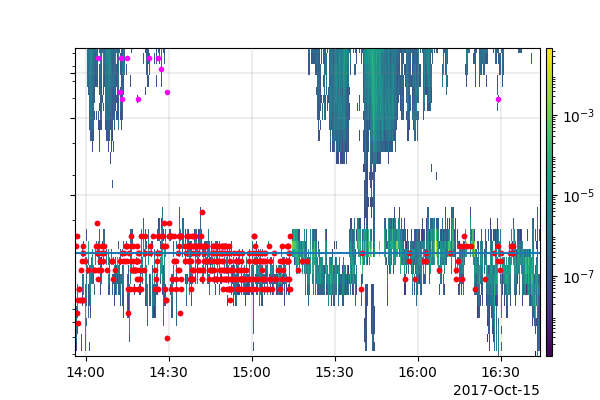

In [235]:
%matplotlib widget
from pyrfu.plot import plot_line, plot_spectr
import matplotlib.pyplot as plt
from epsd_peakfinder import epsd_peakfinder
from scipy.ndimage import uniform_filter1d,gaussian_filter1d

h = np.genfromtxt('sw_tints/compiled_sw_tints.csv', dtype=str,delimiter=',', skip_header=1)
# j = h[np.random.randint(0, len(h))]
# tint = [str(j[0]), str(j[1])]
# ic = j[2]
ic = 1
tint = ['2017-10-15T13:56:10.000000000', '2017-10-15T16:44:10.000000000']
# vsc = mms.get_data("v_edp_fast_l2", tint, 1)
epsd = mms.db_get_ts(f'mms{ic}_dsp_fast_l2_epsd',f'mms{ic}_dsp_epsd_omni', tint)
epsd = 1e3*epsd
fig, ax = plt.subplots(1, figsize=(6, 4))

epsd_cut, f_peaks = epsd_peakfinder(epsd, 1e-9)


def weighted_median(values, weights):
    sorted_idx = np.argsort(values)
    values, weights = values[sorted_idx], weights[sorted_idx]
    cumsum = np.cumsum(weights)
    return values[np.searchsorted(cumsum, 0.5 * cumsum[-1])]

weights = f_peaks.data / np.max(f_peaks.data)  # Normalize weights to favor high frequencies
median_peak = weighted_median(f_peaks.data, weights)

ax_s, ax_c = plot_spectr(ax, epsd_cut, clim='auto', yscale='log', cscale='log')
print(len(f_peaks), np.median(f_peaks))
fpp = f_peaks.where(abs(f_peaks - median_peak) < np.std(f_peaks))
plot_line(ax, f_peaks, linestyle='none', marker='.', color='magenta')
plot_line(ax, fpp, linestyle='none', marker='.', color='red')


ax.axhline(median_peak, 0, 1)



[02-Apr-25 16:08:53] WARNING: /tmp/ipykernel_1543899/898442032.py:13: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(epsd.data)  # Spectral power



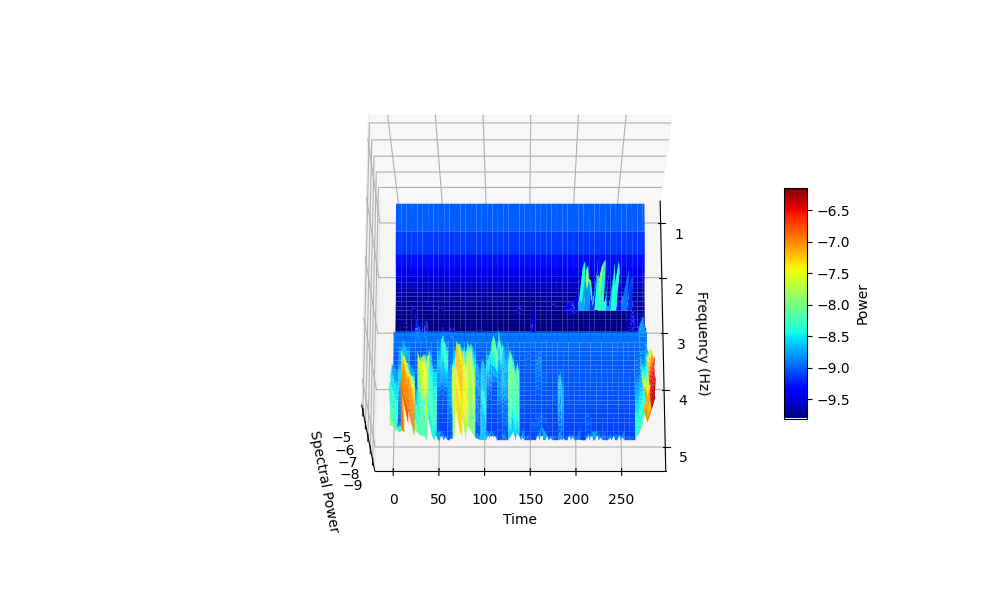

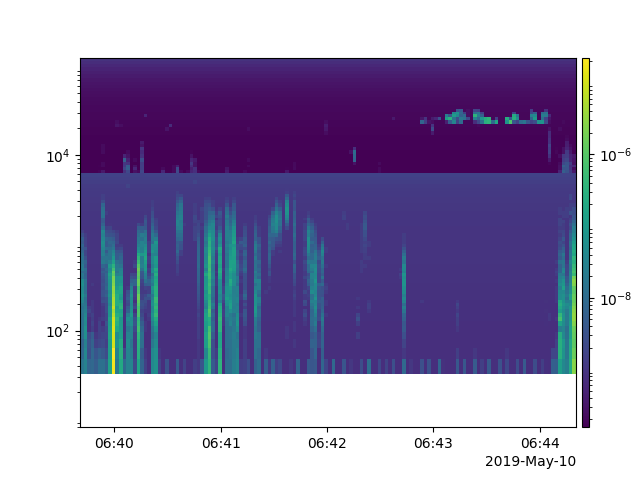

In [183]:
# h = np.genfromtxt('sw_tints/compiled_sw_tints.csv', dtype=str,delimiter=',', skip_header=1)
# j = h[np.random.randint(0, len(h))]
# tint = [str(j[0]), str(j[1])]
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
tint = ['2019-05-10T06:39:40.000000000', '2019-05-10T06:44:20.000000000']
ic = 3
epsd = mms.db_get_ts(f'mms{ic}_dsp_fast_l2_epsd',f'mms{ic}_dsp_epsd_omni', tint)
# Extract data from xarray.DataArray
time_numeric = (epsd.time - epsd.time[0]) / np.timedelta64(1, 's')

X, Y = np.meshgrid(np.log10(np.flip(epsd.E_Freq.data)), time_numeric)  # Frequency and time meshgrid
Z = np.log10(epsd.data)  # Spectral power

fig, ax = plt.subplots(1)
ax_s, ax_c = plot_spectr(ax, epsd, clim='auto', yscale='log', cscale='log')


# Create figure and 3D axis
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=70, azim=0, roll=0)
# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='jet', edgecolor='none')

# Labels and colorbar
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Time')
ax.set_zlabel('Spectral Power')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Power')





plt.show()
